In [1]:
! pip install btester requests tqdm yfinance quantstats==0.0.59

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import yfinance as yf
import pandas as pd

start = '2006-01-01'
end = '2024-01-01'

symbol = 'AAPL'

data = yf.download(symbol, start, end)
benchmark = data['Close']

[*********************100%%**********************]  1 of 1 completed


In [3]:
from btester import Strategy

def UpBreakout(ser: pd.Series, period: int):
    return (ser.rolling(period).max().diff() > 0).values

def DownBreakout(ser: pd.Series, period: int):
    return (ser.rolling(period).min().diff() < 0).values

class BreakoutStrategy(Strategy):
    def init(self, buy_period: int, sell_period: int):
        self.buy_signal = UpBreakout(self.data['Close'], buy_period)
        self.sell_signal = DownBreakout(self.data['Close'], sell_period)

    def next(self, i, record):
        if self.buy_signal[i-1]:
            self.open(price=record['Open'])

        if self.sell_signal[i-1]:
            self.close(price=record['Open'])

In [4]:
from btester import Backtest
backtest = Backtest(BreakoutStrategy, data, commission=.001, cash=1e6)

In [5]:
import quantstats as qs
from itertools import product
from tqdm.contrib.concurrent import process_map

parameters = ['Buy period','Sell period']
values = [[5, 10, 20, 50, 75, 100, 150, 200], [5, 10, 20, 50, 75, 100, 150, 200]]

def run(v):
    result = backtest.run(*v)
    returns = result.returns
    return [*v, returns.iloc[0], returns.iloc[-1], qs.stats.max_drawdown(returns) * 100, qs.stats.cagr(returns) * 100, qs.stats.sharpe(returns)]

optimization_results = process_map(run, list(product(*values)))
optimization_results = pd.DataFrame(optimization_results, columns=[*parameters,'Initial Capital','Cumulative Return','Max Drawdown (%)','CAGR (%)','Sharpe Ratio'])
optimization_results.set_index([*parameters], inplace=True)

100%|██████████| 64/64 [00:01<00:00, 42.02it/s]


In [6]:
optimization_results_sorted = optimization_results.sort_values('Sharpe Ratio', ascending=False)
optimization_results_sorted

,,Initial Capital,Cumulative Return,Max Drawdown (%),CAGR (%),Sharpe Ratio
Buy period,Sell period,,,,,
100,75,1000000.0,5.784462e+07,-30.405845,25.290575,1.102270
150,75,1000000.0,3.989181e+07,-36.591328,22.730223,1.030636
75,75,1000000.0,4.761179e+07,-40.874912,23.942585,1.015744
10,20,1000000.0,3.947630e+07,-49.830806,22.658842,1.011185
100,100,1000000.0,4.437432e+07,-35.929618,23.458572,1.008587
...,...,...,...,...,...,...
75,10,1000000.0,5.004342e+06,-22.519268,9.360006,0.689733
150,5,1000000.0,3.271799e+06,-26.153082,6.807958,0.629626
100,10,1000000.0,3.852968e+06,-28.325020,7.782722,0.605212


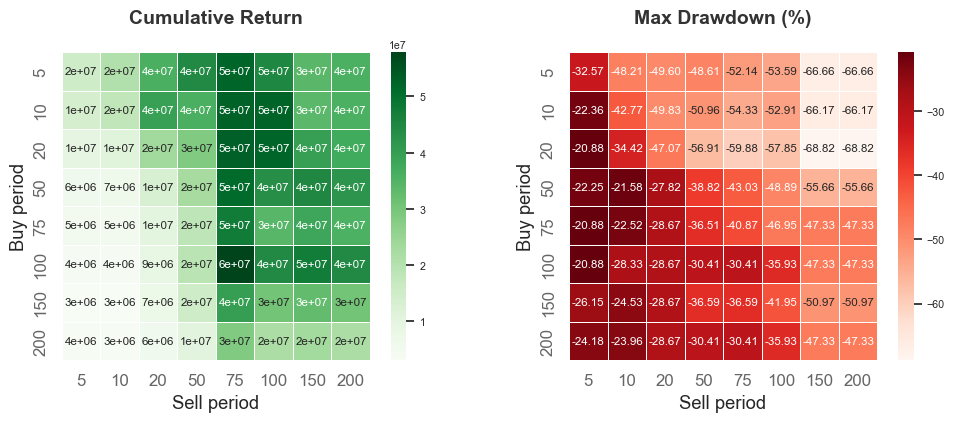

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].set_title('Cumulative Return\n', fontsize=14, fontweight='bold')
ax[1].set_title('Max Drawdown (%)\n', fontsize=14, fontweight='bold')

reshape = lambda d: pd.DataFrame(d.values.reshape(len(d.index.levels[0]), len(d.index.levels[1])), d.index.levels[0], d.index.levels[1])

sns.set(font_scale=.7)
sns.heatmap(reshape(optimization_results['Cumulative Return']), ax=ax[0], annot=True, fmt='.0g', linewidth=.5, square=True, cmap='Greens')
sns.heatmap(reshape(optimization_results['Max Drawdown (%)']), ax=ax[1], annot=True, fmt='.2f', linewidth=.5, square=True, cmap='Reds')

plt.show()

In [8]:
best_params = optimization_results_sorted.index[0]
best_params

(100, 75)

In [9]:
result = backtest.run(*best_params)

In [10]:
import quantstats as qs
qs.reports.metrics(result.returns, benchmark)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2006-01-03  2006-01-03
End Period          2023-12-29  2023-12-29
Risk-Free Rate      0.0%        0.0%
Time in Market      68.0%       100.0%

Cumulative Return   5,684.46%   7,111.83%
CAGR﹪              25.29%      26.84%

Sharpe              1.1         0.9
Prob. Sharpe Ratio  100.0%      99.99%
Sortino             1.66        1.32
Sortino/√2          1.17        0.94
Omega               1.27        1.27

Max Drawdown        -30.41%     -60.87%
Longest DD Days     708         720

Gain/Pain Ratio     0.27        0.18
Gain/Pain (1M)      1.69        1.0

Payoff Ratio        1.1         1.11
Profit Factor       1.27        1.18
Common Sense Ratio  1.43        1.25
CPC Index           0.75        0.69
Tail Ratio          1.13        1.07
Outlier Win Ratio   7.39        3.49
Outlier Loss Ratio  4.12        3.53

MTD                 -2.87%      1.36%
3M                  -2.87%      12

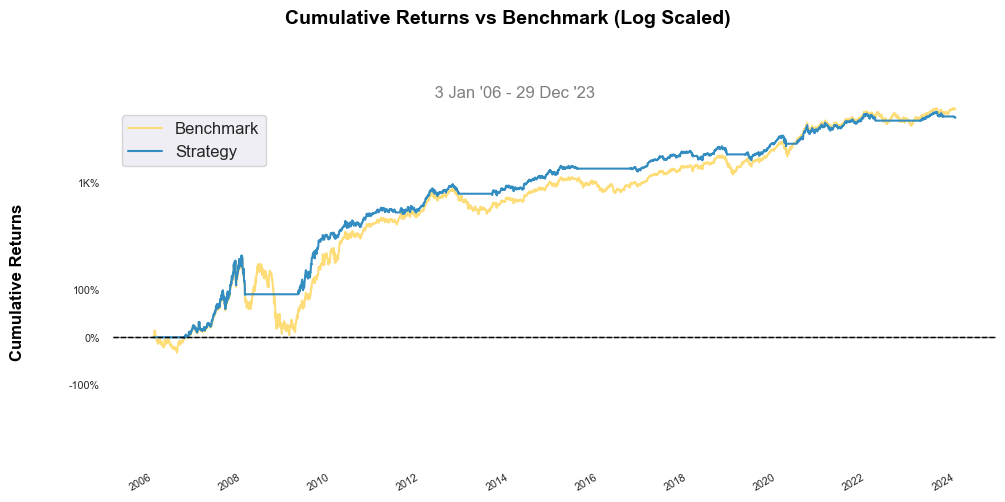

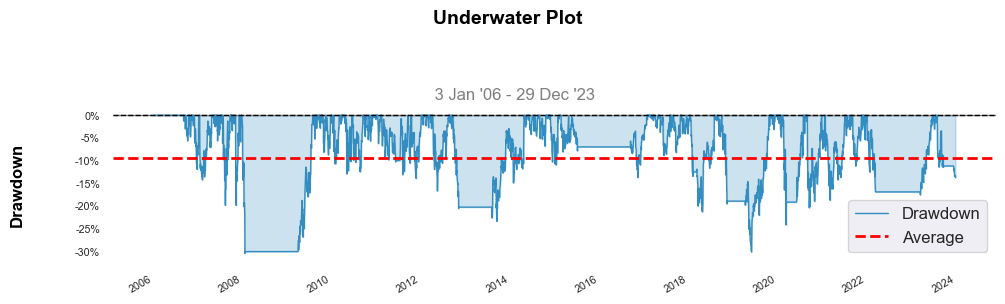

In [11]:
qs.plots.log_returns(result.returns, benchmark, fontname='sans-serif')
qs.plots.drawdown(result.returns, figsize=(10,3), fontname='sans-serif')

In [14]:
trades = pd.DataFrame(result.trades)
trades

,symbol,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
0,None,2006-09-08,2008-01-24,2.620357,4.999643,381246.137473,9.070935e+05,90.800062,2905.095524,1.904188e+06
1,None,2009-04-03,2011-06-13,4.078214,11.685714,466450.771251,3.548524e+06,186.539973,7353.096344,5.445359e+06
2,None,2011-07-18,2012-11-08,13.051071,20.022499,416817.853525,2.905816e+06,53.416519,13785.654561,8.337389e+06
3,None,2013-08-06,2015-07-09,16.715000,30.962500,498298.547364,7.099508e+06,85.237806,23757.628878,1.541314e+07
4,None,2016-09-15,2018-02-09,28.465000,39.267502,540935.963087,5.843462e+06,37.950120,36638.946193,2.121996e+07
5,None,2018-03-12,2018-11-15,45.072498,47.097500,470325.913640,9.524107e+05,4.492765,43349.938599,2.212902e+07
6,None,2019-04-11,2020-03-13,50.212502,66.222504,440267.182134,7.048679e+06,31.884494,51262.511636,2.912644e+07
7,None,2020-06-08,2022-03-14,82.562500,151.449997,352428.065332,2.427789e+07,83.436787,82472.571563,5.332185e+07
8,None,2023-03-17,2023-09-22,156.080002,174.669998,341290.267677,6.344585e+06,11.910556,112881.756034,5.955356e+07


In [13]:
open_positions = pd.DataFrame(result.open_positions)
open_positions

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value
0,None,2023-12-14,2023-12-29,198.020004,192.529999,300444.712216,-1.649443e+06,-2.77245,5.784462e+07
